<a href="https://colab.research.google.com/github/Fredpwol/clean-tube/blob/master/Youtube_Thumbnail_CLickBait_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Youtube Thumbnail detection using transfer learning

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np


from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

I'll get the data used for training on my google drive and split it into test and training images

In [3]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

Getting data stored on google drive

In [4]:
!unzip -uq "/content/drive/My Drive/data_manualy_tag.zip" -d "/content/drive/My Drive/"

In [5]:
import os
data_path = "/content/drive/MyDrive/data_manualy_tag/"
images_dir = os.listdir(data_path)
IMAGE_RES = 224
images_dir[:5]

['0_EAHzlJFPWLc.jpg',
 '0_lyjnEXBb3Bk.jpg',
 '0_X1uaOtiJ9Vc.jpg',
 '0_IKXkvzqJ6cc.jpg',
 '0_e7Hko3xysFQ.jpg']

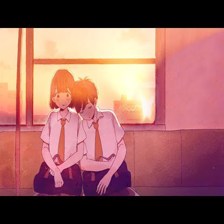

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

im  = Image.open(data_path + images_dir[0]).resize((IMAGE_RES, IMAGE_RES))
im

In [7]:
def preprocess_image(image):
  res = np.array(image.resize((IMAGE_RES, IMAGE_RES)), dtype=np.float32)
  res /= 255.0
  return res
  

In [66]:
import re

images_data = []
images_label = []

label_match = ["0_", "25_", "50_", "75_", "100_"]

for image in os.listdir(data_path):
  processed_image = preprocess_image(Image.open(os.path.join(data_path, image)))
  for i, l in enumerate(label_match):
    if image.startswith(l):
      if (int(l.strip("_")) >= 50):
        images_data.append(processed_image)
        images_label.append(1)
      else:
        images_data.append(processed_image)
        images_label.append(0)

images_data = np.array(images_data)
images_label = np.array(images_label)
print(images_data.shape, images_label.shape)

(1591, 224, 224, 3) (1591,)


In [67]:
images_label = images_label.reshape(-1, 1)
images_label.shape

(1591, 1)

In [68]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# images_label = le.fit_transform(images_label)
images_label = to_categorical(images_label)

In [69]:
images_label.shape

(1591, 2)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_data, images_label, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((1272, 224, 224, 3), (1272, 2))

## Download classifier from tensorflow hub
For this project i'm going to use the mobilenet model because of it's few parameters and also it's lightweight which is good for production.

In [13]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [14]:
feature_extractor.trainable = False

In [71]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [72]:
batch_size = 8
data_size = len(X_train)
split_size = 0.2
#splitting train data to train and validation with a 80 : 20 ratio
train_generator = train_datagen.flow(X_train[:data_size - int(data_size * split_size)], y_train[:data_size - int(data_size * split_size)], batch_size=batch_size)
valid_generator = train_datagen.flow(X_train[data_size - int(data_size * split_size) : ], y_train[data_size - int(data_size * split_size): ], batch_size=batch_size)
test_generator = test_datagen.flow(X_test, batch_size=1)

In [74]:
model = tf.keras.Sequential([
                             feature_extractor,
                            #  layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
                            #  layers.MaxPooling2D(pool_size=(2, 2)), 
                            #  layers.Flatten(),
                             layers.Dropout(0.2),
                             layers.Dense(16, activation="tanh"),
                             layers.Dropout(0.2),
                             layers.Dense(2, activation="sigmoid")
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                20496     
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 34        
Total params: 2,278,514
Trainable params: 20,530
Non-trainable params: 2,257,984
_________________________________________________________________


In [75]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 20
history = model.fit_generator(train_generator, validation_data=valid_generator,
                              # steps_per_epoch=len(X_train) // batch_size,
                              epochs=EPOCHS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
128/128 [==============================] - 16s 110ms/step - loss: 0.6382 - accuracy: 0.6849 - val_loss: 0.4403 - val_accuracy: 0.7992
Epoch 2/20
128/128 [==============================] - 13s 103ms/step - loss: 0.5439 - accuracy: 0.7307 - val_loss: 0.4207 - val_accuracy: 0.7992
Epoch 3/20
128/128 [==============================] - 13s 103ms/step - loss: 0.5119 - accuracy: 0.7481 - val_loss: 0.3949 - val_accuracy: 0.8307
Epoch 4/20
128/128 [==============================] - 13s 103ms/step - loss: 0.4621 - accuracy: 0.7882 - val_loss: 0.4022 - val_accuracy: 0.8228
Epoch 5/20
128/128 [==============================] - 13s 104ms/step - loss: 0.4529 - accuracy: 0.8297 - val_loss: 0.3711 - val_accuracy: 0.8425
Epoch 6/20
128/128 [==============================] - 13s 104ms/step - loss: 0.4734 - accuracy: 0.7861 - val_loss: 0.3637 - val_accuracy: 0.8583
Epoch 7/20
128/128 [==============================] - 13s 104ms/step - loss: 0.4671 - accuracy: 0.7851 - val_loss: 0.3599 - val_ac

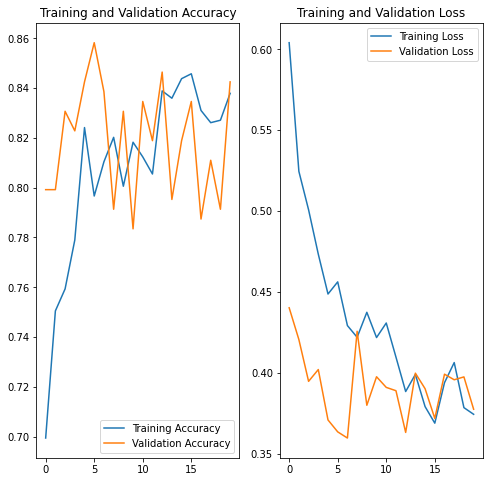

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
predict = model.predict(X_train)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

array([0, 0, 1, ..., 0, 0, 0])

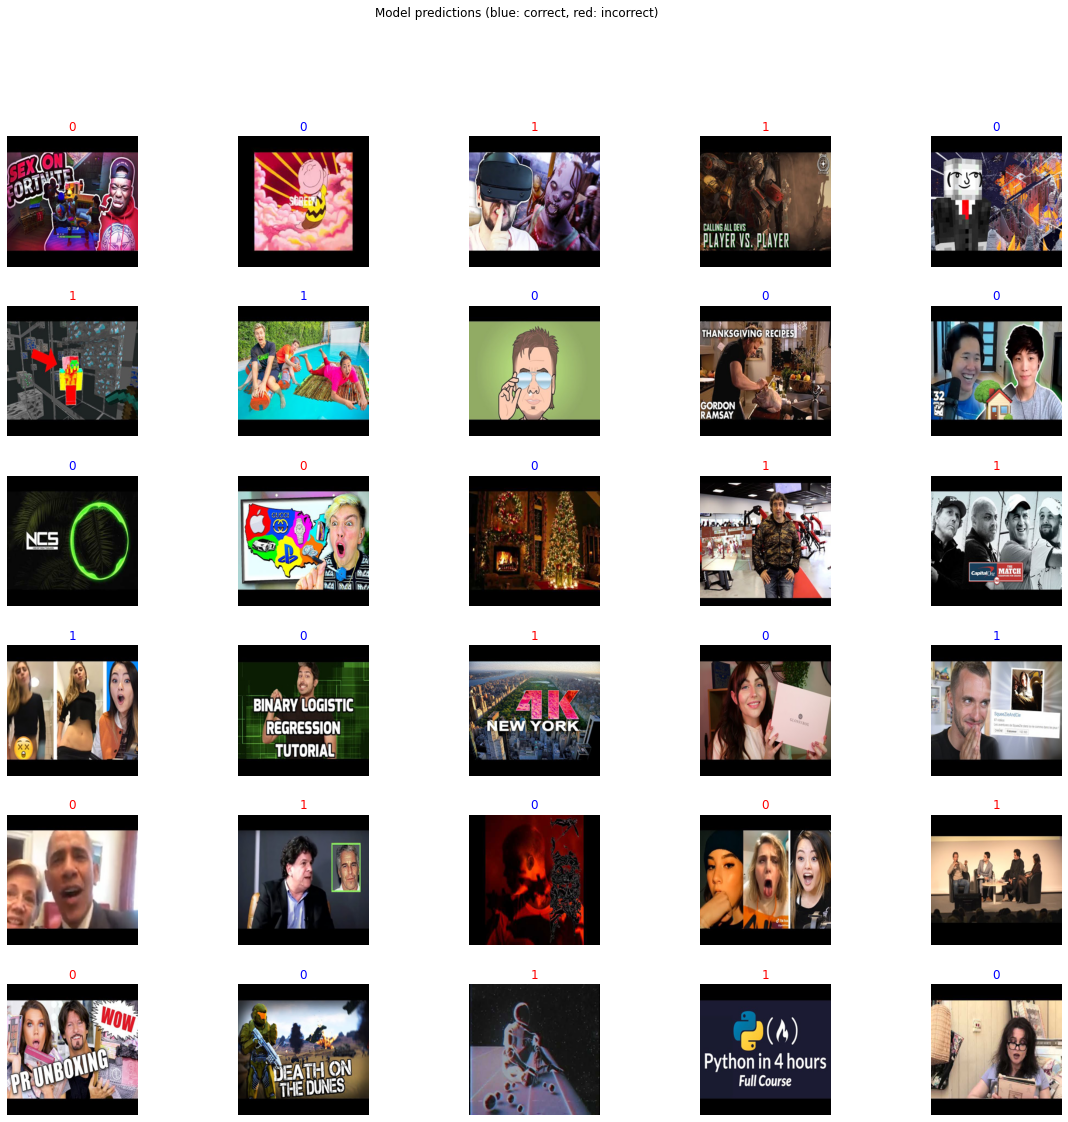

In [80]:
plt.figure(figsize=(20,18))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(X_test[n])
  color = "blue" if y_classes[n] == np.argmax(y_test[n]) else "red"
  plt.title(y_classes[n], color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [82]:
import time
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1609964765


In [83]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [84]:
!zip -r model.zip {export_path_sm}

  adding: 1609964765/ (stored 0%)
  adding: 1609964765/variables/ (stored 0%)
  adding: 1609964765/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: 1609964765/variables/variables.index (deflated 74%)
  adding: 1609964765/assets/ (stored 0%)
  adding: 1609964765/saved_model.pb (deflated 92%)


In [85]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>